In [1]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2  # will autoreload all packages imported with %aimport

In [2]:
%reload_ext autoreload
%autoreload 2 

import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from pickle import load as pload
from json import load as load_json

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src

from src.model.hydroshoot_experiment import load_runs, HydroShootExperiment

## Loading experiment data

In [3]:
EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug'
assert(os.path.isdir(EXPERIMENT_ROOT))

In [4]:
# Loading all the data
runs = load_runs(EXPERIMENT_ROOT)
print(len(runs))

84


In [5]:
print('Targets:', runs[0].get_targets())
print('Variables:', runs[0].get_state_variables())


Targets: ('input_Tac', 'input_u', 'input_hs', 'input_Rg', 'output_Rg', 'output_An', 'output_E', 'output_Tleaf')
Variables: ('Ci', 'gb', 'Ei', 'FluxC', 'Tlc', 'An', 'Flux', 'psi_head', 'u', 'E', 'Eabs', 'gs', 'par_photo.dHd')


## Preprocess data for learning

In [6]:
runs[0].n_steps()

168

In [7]:
from src.learning.preprocessing import preprocess_data, reshape_data, generate_mask

STATE_VAR = 'Tlc'
TARGET = 'output_Rg'
STATE_SIZE = 64
SAMPLES_PER_RUN = 2
WARMUP_STEPS = 24
DAYLIGHT_MASK = generate_mask(5, 21)

X, y = preprocess_data(runs, STATE_VAR, TARGET,
    state_size=STATE_SIZE,
    samples_per_run=SAMPLES_PER_RUN,
    warmup_steps=WARMUP_STEPS,
    mask=DAYLIGHT_MASK,
)

print(X.shape, y.shape)

(84, 2, 6, 16, 64) (84, 2, 6, 16)


In [8]:
from src.learning.grouping import alternating_groups

N_CV_GROUPS = 2

X_train, y_train = reshape_data(X, y)
groups = alternating_groups(X, n_groups=N_CV_GROUPS)

print(X_train.shape, y_train.shape, groups.shape)

(16128, 64) (16128,) (16128,)


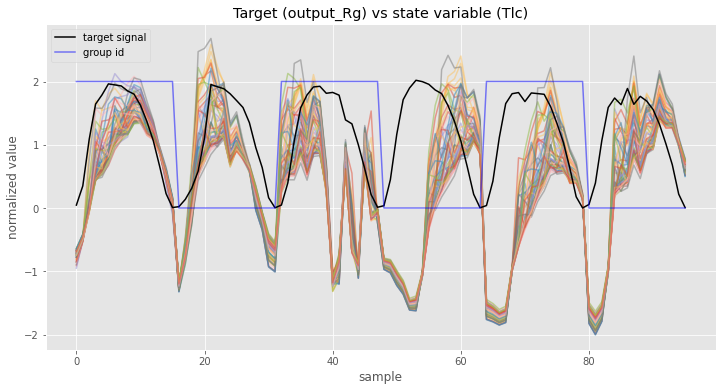

In [9]:
size = 16
point = 2000

with plt.style.context('ggplot'):
  plt.figure(figsize=(12, 6))
  plt.plot(X_train[point:point + 6 * size], alpha=0.5)
  plt.plot(y_train[point:point + 6 * size] / y_train.mean(), c='black', label='target signal')
  plt.plot(groups[point:point + 6 * size] / groups.mean(), c='blue', alpha=0.5, label="group id")
  plt.title(f'Target ({TARGET}) vs state variable ({STATE_VAR})')
  plt.xlabel('sample')
  plt.ylabel('normalized value')
  plt.legend()
  plt.show()

## Training readout functions

In [10]:
from sklearn.model_selection import LeaveOneGroupOut
folds = LeaveOneGroupOut()

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.learning.scorers import nmse_scorer
from util import print_cv_scores, print_search_scores, print_search_best_params

readout = Pipeline([
    ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

cv_scores = cross_validate(readout, X_train, y_train, 
    groups=groups, 
    cv=folds, 
    scoring=nmse_scorer, 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=False)

print('--- Untuned score ---')
print_cv_scores(cv_scores)


--- Untuned score ---
  - Train: -0.8447 +/- 0.02001
  - CV:    -0.8595 +/- 0.01966


In [12]:
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 500)

}]

grid_search = GridSearchCV(readout, 
  param_grid=search_grid, 
  cv=folds, 
  scoring=nmse_scorer, 
  n_jobs=-1, 
  verbose=False, 
  return_train_score=True
  )

grid_search.fit(X_train, y_train, groups=groups)

print('\n\n--- Tuned hyperparemeters ---')
print_search_best_params(grid_search)
print_search_scores(grid_search)



--- Tuned hyperparemeters ---
  - ridge_regression__alpha = 102.80732238308647
  - Train: -0.8457 +/- 0.02020
  - CV:    -0.8584 +/- 0.02090


In [13]:
from sklearn.neural_network import MLPRegressor
from IPython.display import clear_output

mlp = MLPRegressor(max_iter=100, verbose=True)

mlp.fit(X_train, y_train)

clear_output()

In [14]:
nmse_scorer(mlp, X_train, y_train)

-0.8193398578195837

In [15]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

X_ = X_train
target = y_train
y_pred = grid_search.predict(X_)

Loading BokehJS ...

In [16]:
from bokeh_tools import inspect_prediction
inspect_prediction(X_, target, y_pred, window=400, offset=8000)
